**E-Commerce Sales Forecasting**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [2]:
orders = pd.read_csv("orders.csv", parse_dates=['Order Date', 'Ship Date'])
products = pd.read_csv("products.csv")

**Merge Data & Preprocessing**

In [3]:
df = orders.merge(products, on="Product ID", how="left")
df['Order Month'] = df['Order Date'].dt.to_period('M').astype(str)
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df.dropna(inplace=True)

In [4]:
for col in ['Category', 'Sub-Category', 'Product Name']:
    if f"{col}_x" in df.columns:
        df[col] = df[f"{col}_x"]
    elif col in df.columns:
        df[col] = df[col]
    else:
        df[col] = "Unknown"

redundant_cols = [c for c in df.columns if any(x in c for x in ['_x', '_y']) and c not in ['Category', 'Sub-Category', 'Product Name']]
df.drop(columns=redundant_cols, inplace=True)

**Exploratory Data Analysis**

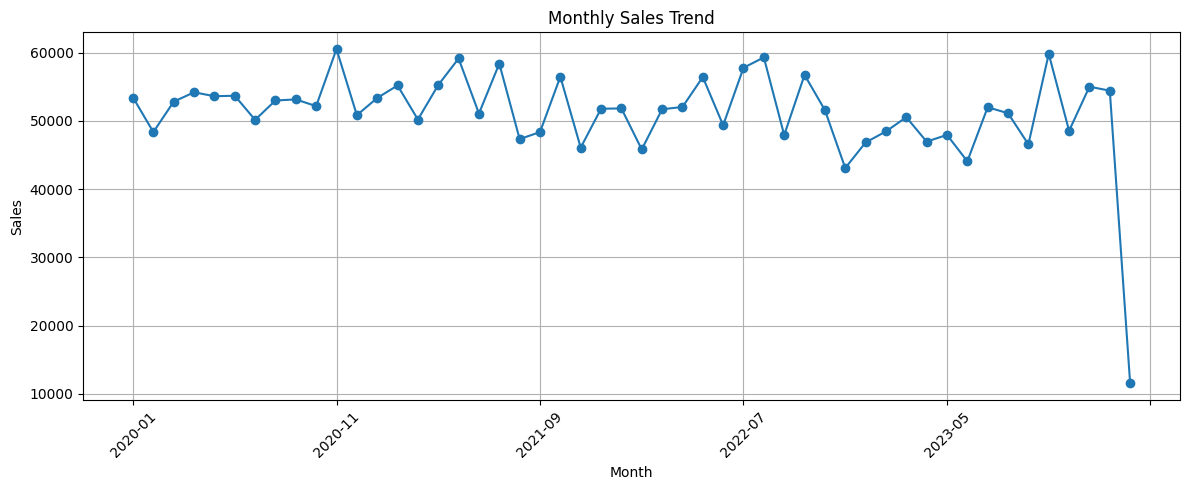

In [5]:
plt.figure(figsize=(12,5))
df.groupby('Order Month')['Sales'].sum().plot(kind='line', marker='o')
plt.title("Monthly Sales Trend")
plt.ylabel("Sales")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
px.bar(region_sales, title='Total Sales by Region').show()

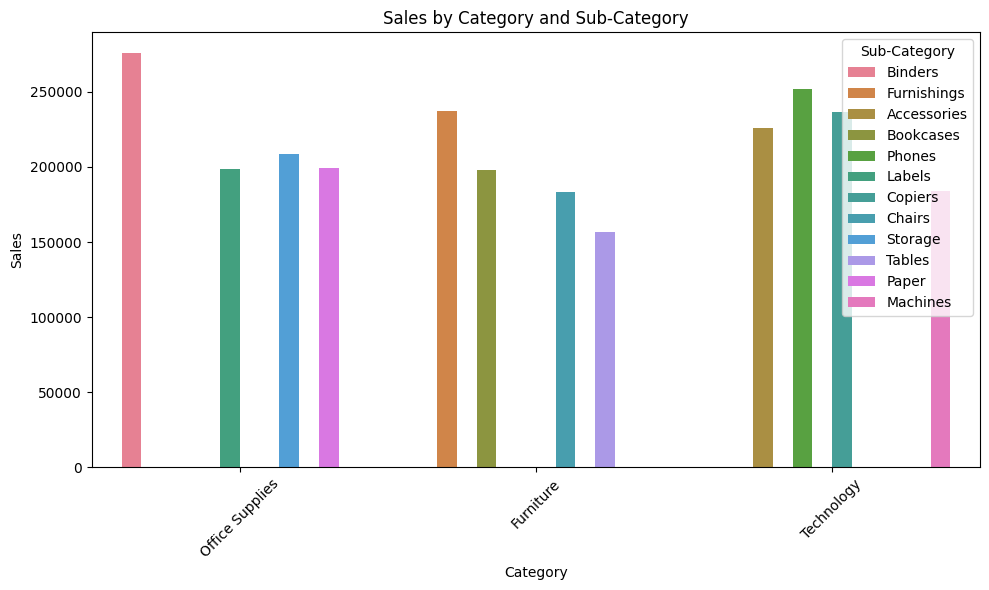

In [7]:
if 'Category' in df.columns and 'Sub-Category' in df.columns:
    plt.figure(figsize=(10,6))
    sns.barplot(data=df, x='Category', y='Sales', estimator=sum, ci=None, hue='Sub-Category')
    plt.title("Sales by Category and Sub-Category")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'Category' or 'Sub-Category' column not found in the dataset.")
    print("Available columns are:", df.columns.tolist())

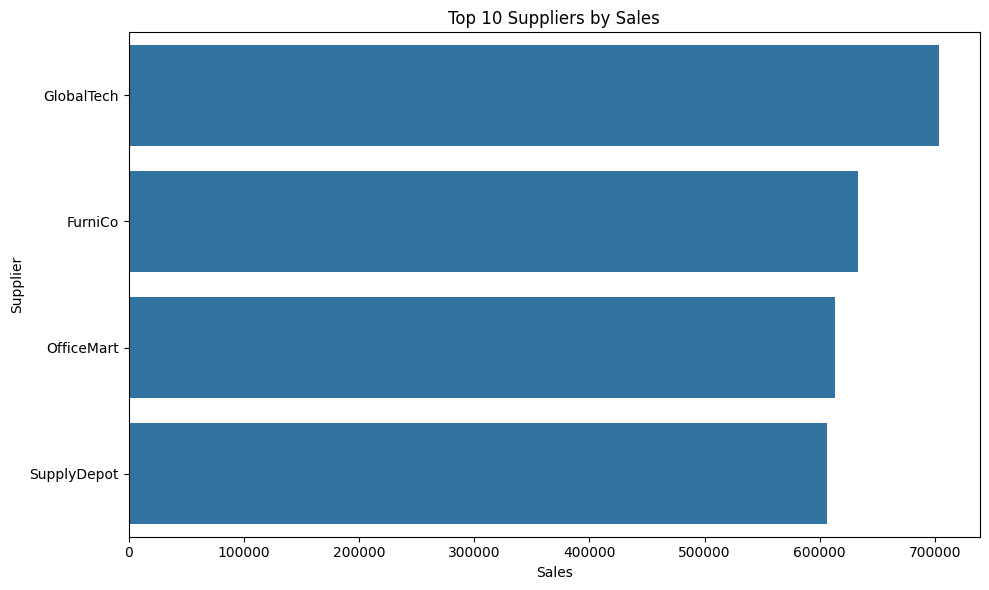

In [8]:
supplier_sales = df.groupby('Supplier')['Sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=supplier_sales.values, y=supplier_sales.index)
plt.title("Top 10 Suppliers by Sales")
plt.xlabel("Sales")
plt.tight_layout()
plt.show()

In [9]:
df['DayOfWeek'] = df['Order Date'].dt.dayofweek
df['Month'] = df['Order Date'].dt.month
df['Year'] = df['Order Date'].dt.year
df['Days to Ship'] = (df['Ship Date'] - df['Order Date']).dt.days
encoded_df = pd.get_dummies(df[['Segment', 'Region', 'Category', 'Sub-Category']], drop_first=True)
df = pd.concat([df, encoded_df], axis=1)

In [10]:
features = ['Quantity', 'Discount', 'Profit', 'Base Price', 'DayOfWeek', 'Month', 'Year', 'Days to Ship'] + list(encoded_df.columns)
X = df[features]
y = df['Sales']

**Model Training**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

**Evaluation**

In [12]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
accuracy_rate = r2 * 100

In [13]:
print("\n📊 Predictive Model Accuracy:")
print(f"✅ RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"✅ R² Score: {r2:.2f}")
print(f"🎯 Predictive Accuracy Rate: {accuracy_rate:.2f}%")


📊 Predictive Model Accuracy:
✅ RMSE (Root Mean Squared Error): 32.80
✅ R² Score: 0.95
🎯 Predictive Accuracy Rate: 95.31%


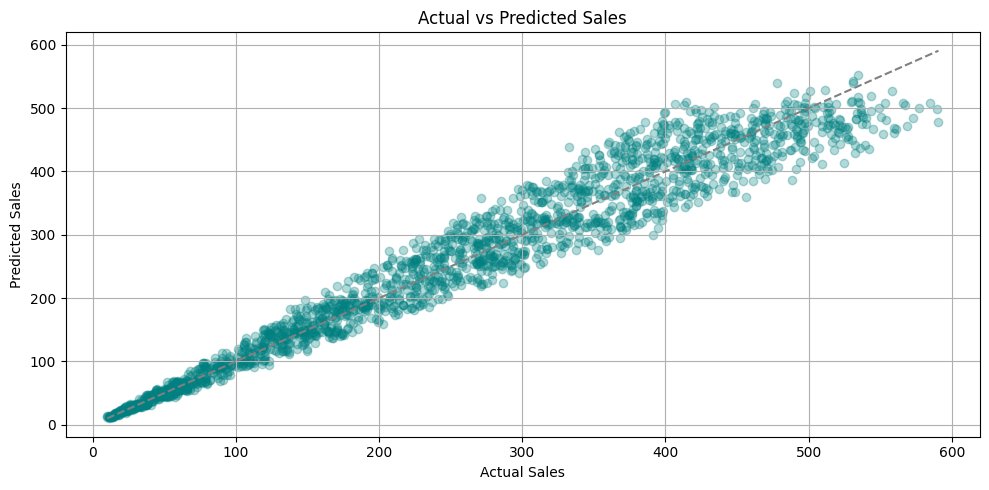

In [14]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred, alpha=0.3, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
plt.title("Actual vs Predicted Sales")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

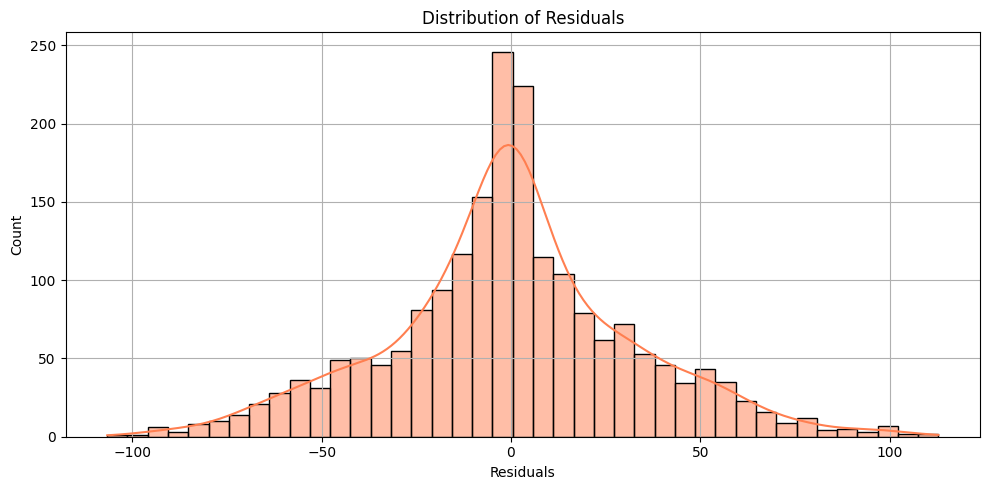

In [15]:
residuals = y_test - y_pred
plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True, color="coral")
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

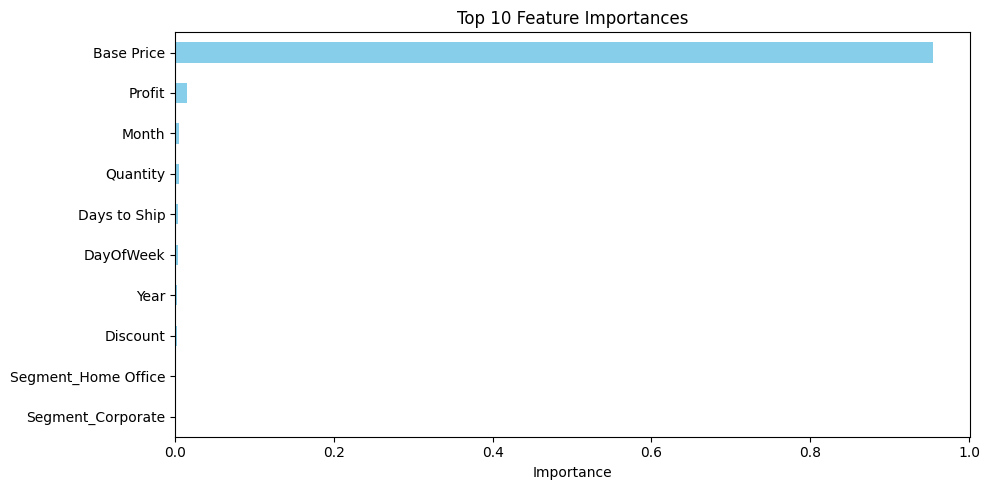

In [16]:
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
feat_imp.head(10).sort_values().plot(kind='barh', color="skyblue")
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

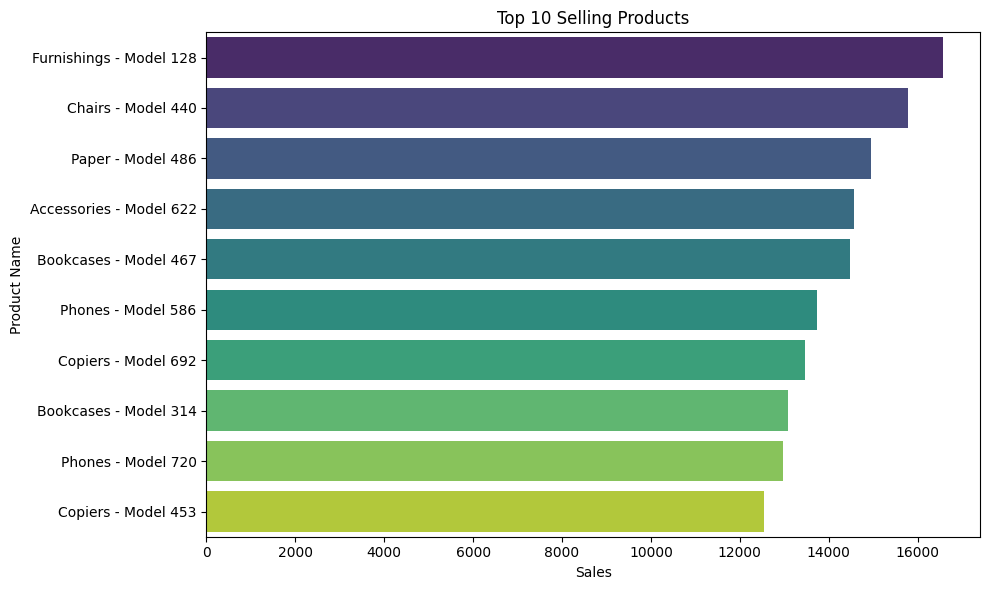

In [17]:
top_products = df.groupby('Product Name')['Sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.title("Top 10 Selling Products")
plt.xlabel("Sales")
plt.tight_layout()
plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn1hl82ug/59ehy10d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn1hl82ug/fxigt766.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91892', 'data', 'file=/tmp/tmpn1hl82ug/59ehy10d.json', 'init=/tmp/tmpn1hl82ug/fxigt766.json', 'output', 'file=/tmp/tmpn1hl82ug/prophet_modelk_isbxau/prophet_model-20250507125412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:54:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:54:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


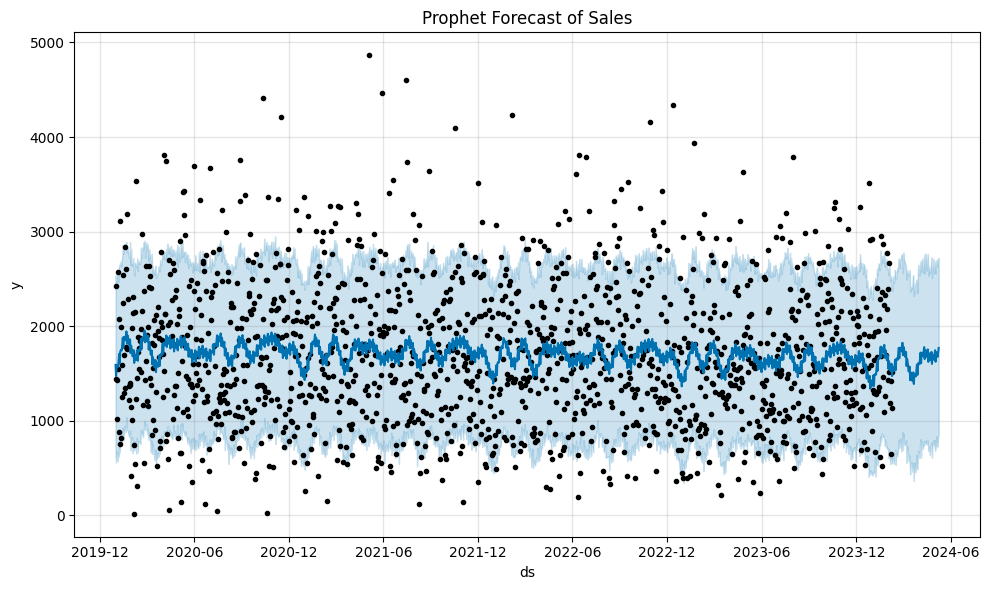

In [18]:
prophet_df = df.groupby('Order Date')["Sales"].sum().reset_index()
prophet_df.columns = ['ds', 'y']
m = Prophet()
m.fit(prophet_df)
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)
m.plot(forecast)
plt.title("Prophet Forecast of Sales")
plt.tight_layout()
plt.show()

**Strategic Insights**

In [19]:
print("\nStrategic Recommendations:")
print("1. Expand supply partnerships with top-performing suppliers.")
print("2. Increase inventory for high-demand sub-categories.")
print("3. Reduce shipping delays to improve customer satisfaction.")
print("4. Use forecast insights to align marketing campaigns.")
print("5. Reassess low-performing products and regions.")


Strategic Recommendations:
1. Expand supply partnerships with top-performing suppliers.
2. Increase inventory for high-demand sub-categories.
3. Reduce shipping delays to improve customer satisfaction.
4. Use forecast insights to align marketing campaigns.
5. Reassess low-performing products and regions.
